# Imports

In [2]:
import os
import sqlite3
import pandas as pd
from pathlib import Path
import requests
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# FirstTry

In [3]:
path_to_sqlite = Path.cwd().parent / "output" / "news_data.sqlite"
path_to_sqlite

PosixPath('/Users/antonioaleksic/Documents/ADSC1_Prüfungsleistung/ADSC1/output/news_data.sqlite')

In [4]:
connection = sqlite3.connect(path_to_sqlite)
query = "SELECT * FROM news"
df = pd.read_sql_query(query, connection)
df.head()

,Zeitung,Pfad,Datum,Überschrift,Text
0,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,Der richtige Mann in der falschen Partei?,Boris Pistorius verzichtet auf die Kandidatur ...
1,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,Das Ende einer bizarren K-Frage,Pistorius hätte die Debatte im Keim ersticken ...
2,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,Was das Northvolt-Debakel für Europa bedeutet,Der schwedische Batterie-Pionier Northvolt käm...
3,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,Das zähe Klimaringen in Baku nimmt kein Ende,Auch die Verlängerung ins Wochenende hinein ha...
4,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,"„Wir kommen nicht so schnell voran, wie es mög...",Kommenden Montag findet in Berlin ein Long-Cov...


In [5]:
df.shape

(45143, 5)

## Rows die gelöscht werden müssen

- die keine Überschriften haben

In [6]:
df[(df["Überschrift"] == " ") & (df["Text"] != " ")].shape

(0, 5)

In [7]:
df[(df["Überschrift"] == " ") & (df["Text"] == " ")].shape

(557, 5)

In [8]:
45143-557

44586

In [9]:
df.drop(df[df["Überschrift"] == " "].index, inplace=True)
df.shape

(44586, 5)

LOWERCASING

In [10]:
df["Überschrift"] = df["Überschrift"].str.lower()
df["Text"] = df["Text"].str.lower()
df.head()

,Zeitung,Pfad,Datum,Überschrift,Text
0,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,der richtige mann in der falschen partei?,boris pistorius verzichtet auf die kandidatur ...
1,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,das ende einer bizarren k-frage,pistorius hätte die debatte im keim ersticken ...
2,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,was das northvolt-debakel für europa bedeutet,der schwedische batterie-pionier northvolt käm...
3,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,das zähe klimaringen in baku nimmt kein ende,auch die verlängerung ins wochenende hinein ha...
4,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,"„wir kommen nicht so schnell voran, wie es mög...",kommenden montag findet in berlin ein long-cov...


In [11]:
#df["Überschrift"] = df["Überschrift"].str.replace(r'[^a-zA-ZäöüÄÖÜß ]', '', regex=True)
#df["Text"] = df["Text"].str.replace(r'[^a-zA-ZäöüÄÖÜß ]', '', regex=True)
df["Überschrift"] = df["Überschrift"].str.replace(r'[^a-zA-ZäöüÄÖÜß -]', '', regex=True)
df["Text"] = df["Text"].str.replace(r'[^a-zA-ZäöüÄÖÜß -]', '', regex=True)
df.head()

,Zeitung,Pfad,Datum,Überschrift,Text
0,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,der richtige mann in der falschen partei,boris pistorius verzichtet auf die kandidatur ...
1,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,das ende einer bizarren k-frage,pistorius hätte die debatte im keim ersticken ...
2,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,was das northvolt-debakel für europa bedeutet,der schwedische batterie-pionier northvolt käm...
3,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,das zähe klimaringen in baku nimmt kein ende,auch die verlängerung ins wochenende hinein ha...
4,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,wir kommen nicht so schnell voran wie es mögli...,kommenden montag findet in berlin ein long-cov...


In [12]:
stopwords_url = "https://raw.githubusercontent.com/solariz/german_stopwords/master/german_stopwords_full.txt"
stopwords = requests.get(stopwords_url, allow_redirects=True).text.split("\n")[9:]
stopwords

['ab',
 'aber',
 'abermaliges',
 'abermals',
 'abgerufen',
 'abgerufene',
 'abgerufener',
 'abgerufenes',
 'abgesehen',
 'acht',
 'aehnlich',
 'aehnliche',
 'aehnlichem',
 'aehnlichen',
 'aehnlicher',
 'aehnliches',
 'aehnlichste',
 'aehnlichstem',
 'aehnlichsten',
 'aehnlichster',
 'aehnlichstes',
 'aeusserst',
 'aeusserste',
 'aeusserstem',
 'aeussersten',
 'aeusserster',
 'aeusserstes',
 'ähnlich',
 'ähnliche',
 'ähnlichem',
 'ähnlichen',
 'ähnlicher',
 'ähnliches',
 'ähnlichst',
 'ähnlichste',
 'ähnlichstem',
 'ähnlichsten',
 'ähnlichster',
 'ähnlichstes',
 'alle',
 'allein',
 'alleine',
 'allem',
 'allemal',
 'allen',
 'allenfalls',
 'allenthalben',
 'aller',
 'allerdings',
 'allerlei',
 'alles',
 'allesamt',
 'allg',
 'allg.',
 'allgemein',
 'allgemeine',
 'allgemeinem',
 'allgemeinen',
 'allgemeiner',
 'allgemeines',
 'allgemeinste',
 'allgemeinstem',
 'allgemeinsten',
 'allgemeinster',
 'allgemeinstes',
 'allmählich',
 'allzeit',
 'allzu',
 'als',
 'alsbald',
 'also',
 'am',
 '

In [13]:
def remove_stopwords(text, stopwords):
    # Den Text in Kleinbuchstaben umwandeln und dann in Wörter zerlegen
    words = text.lower().split()
    # Stopwords entfernen
    words = [word for word in words if word not in stopwords]
    # Die restlichen Wörter wieder zu einem Text zusammensetzen
    return " ".join(words)

In [14]:
df["Überschrift"] = df["Überschrift"].apply(lambda x: remove_stopwords(x, stopwords))
df["Text"] = df["Text"].apply(lambda x: remove_stopwords(x, stopwords))
df.head()

,Zeitung,Pfad,Datum,Überschrift,Text
0,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,richtige falschen partei,boris pistorius verzichtet kandidatur unterstü...
1,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,bizarren k-frage,pistorius debatte keim ersticken ließ laufen r...
2,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,northvolt-debakel europa bedeutet,schwedische batterie-pionier northvolt kämpft ...
3,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,zähe klimaringen baku,verlängerung wochenende durchbruch weltklimako...
4,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,,kommenden montag berlin long-covid-kongress ch...


In [15]:
# Überprüfe, ob in irgendeiner Spalte genau nur ein Leerzeichen (" ") enthalten ist
rows_with_only_space = df.apply(lambda row: row.astype(str).eq("").any(), axis=1)

# Summe der Zeilen, die nur ein Leerzeichen enthalten
sum_rows_with_only_space = rows_with_only_space.sum()

print(f"Anzahl der Zeilen mit nur Leerzeichen in einer Spalte: {sum_rows_with_only_space}")

Anzahl der Zeilen mit nur Leerzeichen in einer Spalte: 21716


In [16]:
df["text_combined"] = df["Überschrift"] + " " + df["Text"]
df.head()

,Zeitung,Pfad,Datum,Überschrift,Text,text_combined
0,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,richtige falschen partei,boris pistorius verzichtet kandidatur unterstü...,richtige falschen partei boris pistorius verzi...
1,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,bizarren k-frage,pistorius debatte keim ersticken ließ laufen r...,bizarren k-frage pistorius debatte keim erstic...
2,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,northvolt-debakel europa bedeutet,schwedische batterie-pionier northvolt kämpft ...,northvolt-debakel europa bedeutet schwedische ...
3,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,zähe klimaringen baku,verlängerung wochenende durchbruch weltklimako...,zähe klimaringen baku verlängerung wochenende ...
4,FAZ,data-lake_2024_11/2024-11-23-faz.html,2024-11-23,,kommenden montag berlin long-covid-kongress ch...,kommenden montag berlin long-covid-kongress c...


In [17]:
def perform_lda(df, n_topics=10):
    results = {}
    
    # Für jede Zeitung LDA ausführen
    for newspaper in df['Zeitung'].unique():
        # Filtere DataFrame nach Zeitung
        newspaper_df = df[df['Zeitung'] == newspaper]
        
        # CountVectorizer erstellen
        vectorizer = CountVectorizer(stop_words=stopwords)
        X = vectorizer.fit_transform(newspaper_df['text_combined'])
        
        # LDA Modell
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda.fit(X)
        
        # Extrahiere die Top Wörter für jedes Thema
        feature_names = np.array(vectorizer.get_feature_names_out())
        topics = []
        
        for topic_idx, topic in enumerate(lda.components_):
            top_words_idx = topic.argsort()[:-11:-1]
            top_words = feature_names[top_words_idx]
            topics.append(" ".join(top_words))
        
        topic_distribution = lda.transform(X)
        # Durchschnitt über alle Dokumente
        avg_topic_distribution = topic_distribution.mean(axis=0)
        
        # Sortiere Topics nach Wahrscheinlichkeit & Indizes nach Wahrscheinlichkeit sortieren (absteigend)
        sorted_indices = np.argsort(avg_topic_distribution)[::-1]  # 
        
        sorted_topics = [topics[i] for i in sorted_indices]  # Sortierte Topics
        sorted_percentages = avg_topic_distribution[sorted_indices]  # Sortierte Wahrscheinlichkeiten
        sorted_percentages = (sorted_percentages / sorted_percentages.sum()) * 100  # In Prozent umrechnen
        
        # Ergebnisse speichern
        results[newspaper] = {"topics": sorted_topics, "percentages": sorted_percentages}
    
    return results

In [18]:
# LDA für das gesamte DataFrame durchführen
topics_by_newspaper = perform_lda(df)

# Ausgabe der Ergebnisse mit Prozenten
for newspaper, data in topics_by_newspaper.items():
    print(f"Top 10 Topics für {newspaper}:")
    for i, (topic, percentage) in enumerate(zip(data["topics"], data["percentages"]), 1):
        print(f"  Topic {i}: {topic} ({percentage:.2f}%)")
    print("\n")

/Users/antonioaleksic/Documents/ADSC1_Prüfungsleistung/ADSC1/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['dat', 'inf', 'zb'] not in stop_words.
  warnings.warn(


Top 10 Topics für FAZ:
  Topic 1: scholz merz assads spd afd beste syrien trump land grünen (11.26%)
  Topic 2: jahr welt deutschland blick faz besten deutschen daten frankfurt zeigen (10.72%)
  Topic 3: jahr reise jobs besten jahren vielfalt beste welt überblick bringt (10.53%)
  Topic 4: trump us trumps präsident donald usa liveblog geld deutschland präsidenten (10.36%)
  Topic 5: ki trump deutschland reise euro millionen deutsche lernen welt new (9.83%)
  Topic 6: deutschland deutsche stellt rolle spielt us grönland lässt bordeaux fokus (9.64%)
  Topic 7: menschen große beste reise kalifornien besten deutschland inklusive booklet jahre (9.63%)
  Topic 8: trump ki donald musk weihnachten elon faz beste deutschland bücher (9.62%)
  Topic 9: frankfurt hessen beste eintracht jobs eltern berlin leben lässt menschen (9.39%)
  Topic 10: deutschland deutschen faz menschen ukraine deutsche amazon etf funktioniert cdu (9.01%)


Top 10 Topics für SZ:
  Topic 1: wissen füllt felder is my trump 

In [25]:
def plot_top_topics(topics_by_newspaper, output_path):
    # Liste zur Speicherung der Daten für den Plot
    plot_data = []

    # Daten für jede Zeitung sammeln
    for newspaper, data in topics_by_newspaper.items():
        for i in range(3):  # Nur die Top 3 Topics nehmen
            plot_data.append({
                "Zeitung": newspaper,
                "Topic": f"{newspaper} - Topic {i+1}: {data['topics'][i]}",  # Zeitung + Topic Nummer
                "Wahrscheinlichkeit (%)": data["percentages"][i]
            })
    
    # DataFrame für die Visualisierung erstellen
    df_plot = pd.DataFrame(plot_data)

    # Stil setzen
    sns.set_theme(style="whitegrid")
    
    # Balkendiagramm mit Seaborn
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=df_plot, 
        x="Zeitung", 
        y="Wahrscheinlichkeit (%)", 
        hue="Topic",  # Hue enthält nun Zeitung + Topic
        palette="viridis"
    )
    
    # Titel & Labels
    plt.title("Top 3 Topics pro Zeitung", fontsize=14)
    plt.xlabel("Zeitung", fontsize=12)
    plt.ylabel("Wahrscheinlichkeit (%)", fontsize=12)
    plt.legend(title="Zeitung - Topic", bbox_to_anchor=(1, 1), loc='upper left')  # Legende mit Zeitung + Topic
    
    # Speichern als PDF
    plt.savefig(output_path, bbox_inches="tight")
    plt.close()  # Figure schließen, um Speicher freizugeben

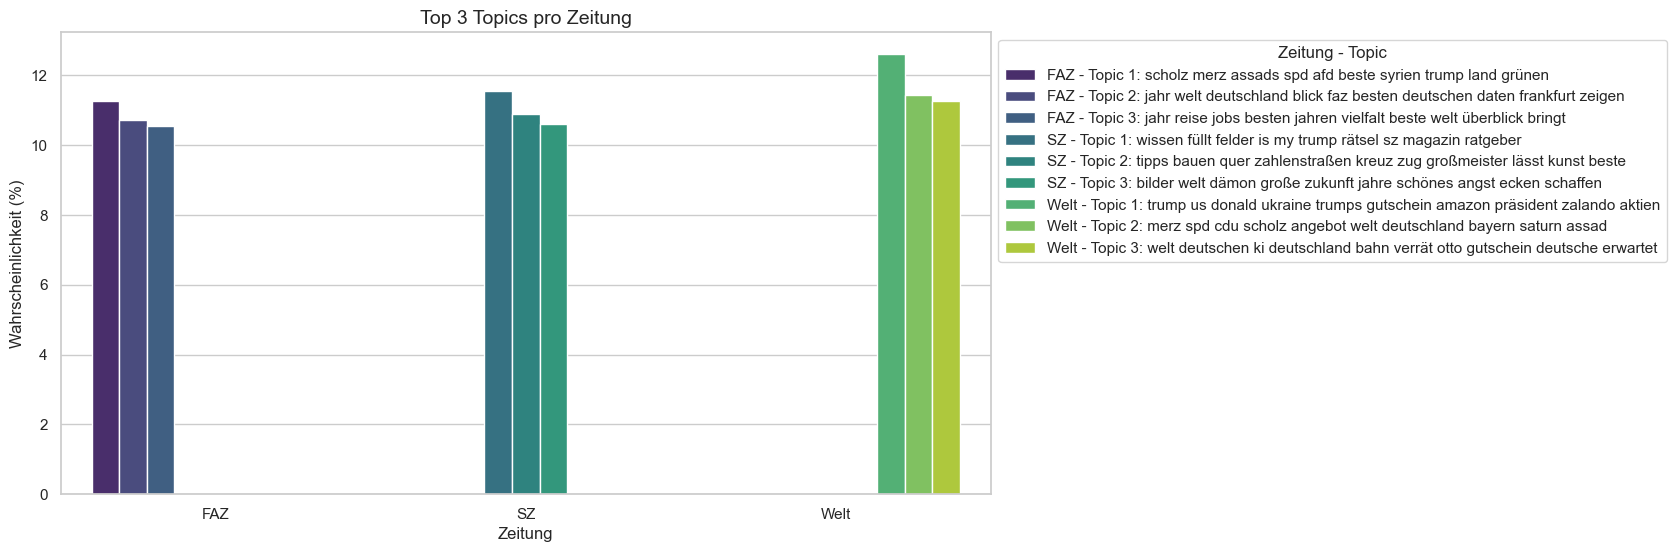

In [23]:
plot_top_topics(topics_by_newspaper)

In [24]:
def save_text_results(topics_by_newspaper, output_path):
    with open(output_path, "w", encoding="utf-8") as file:
        for newspaper, data in topics_by_newspaper.items():
            file.write(f"Top 10 Topics für {newspaper}:\n")
            for i, (topic, percentage) in enumerate(zip(data["topics"], data["percentages"]), 1):
                file.write(f"  Topic {i}: {topic} ({percentage:.2f}%)\n")
            file.write("\n")  # Leerzeile für bessere Lesbarkeit

In [28]:
# Dateipfade für die Ausgaben
#pdf_path = os.path.join("output", "result.pdf")
#txt_path = os.path.join("output", "full_result.txt")

pdf_path = os.path.join(Path.cwd().parent / "output", "result.pdf")
txt_path = os.path.join(Path.cwd().parent / "output", "full_result.txt")

In [ ]:
# Funktionen ausführen und Ergebnisse speichern
plot_top_topics(topics_by_newspaper, pdf_path)
save_text_results(topics_by_newspaper, txt_path)

print(f"Grafik gespeichert unter: {pdf_path}")
print(f"Textdatei gespeichert unter: {txt_path}")

✅ Grafik gespeichert unter: /Users/antonioaleksic/Documents/ADSC1_Prüfungsleistung/ADSC1/output/result.pdf
✅ Textdatei gespeichert unter: /Users/antonioaleksic/Documents/ADSC1_Prüfungsleistung/ADSC1/output/full_result.txt
